In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

## Utilities

In [2]:
def record(sec, rate):
    ex_chunk = 1024
    ex_format = pyaudio.paInt32
    ex_channel = 2
    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=ex_channel, rate=rate, input=True, frames_per_buffer=ex_chunk)
    buf = []
    for i in range(0, int(rate / ex_chunk * sec)):
        data = stream.read(ex_chunk)
        buf.append(np.fromstring(data, 'Int32'))
    stream.stop_stream()
    stream.close()
    p.terminate()
    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / ex_channel, ex_channel])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / ex_channel
    return ex

In [3]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [4]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [5]:
def waveform_encoder(pattern, pulse_1, pulse_2):
    pulse_1 = np.array(pulse_1);
    pulse_2 = np.array(pulse_2);
    return np.array([pulse_1 if c == 0 else pulse_2 for c in pattern]).flatten()

In [6]:
def match_decoder(signal, pulse_1, pulse_2, sample_dt):
    assert int(sample_dt) == sample_dt
    match_1 = np.convolve(signal, pulse_1[::-1])
    match_2 = np.convolve(signal, pulse_2[::-1])
    samples_1 = match_1[np.arange(0, len(match_1), int(sample_dt))]
    samples_2 = match_2[np.arange(0, len(match_2), int(sample_dt))]
    return [1 if x > y else 0 for x, y in zip(samples_1, samples_2)]

## Configuration

In [7]:
rate = 44100 // 2 # else too much computation
origin_dt = 1
pulse_dt = 0.1
delim_dt = 4
analysis_dt = 10
freq_min = 50
freq_max = 8000 # not working with rate // 2

## Channel analysis

In [8]:
#channel = record(analysis_dt, rate)
#Audio(channel, rate=rate)

In [9]:
channel_rate, channel = sp.io.wavfile.read("interference.wav")
channel = channel[:channel_rate * analysis_dt]
channel = sp.signal.resample(channel, rate * analysis_dt)
Audio(channel, rate=rate)

In [10]:
[noise_freq_1, noise_freq_2] = np.argsort(- np.fft.rfft(channel))[:2] / analysis_dt
[noise_freq_1, noise_freq_2]

[852.0, 1209.0]

In [11]:
t = np.linspace(0, analysis_dt, rate * analysis_dt)
channel_sim = np.cos(2 * np.pi * noise_freq_1 * t) + np.cos(2 * np.pi * noise_freq_2 * t)
Audio(channel_sim, rate=rate)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


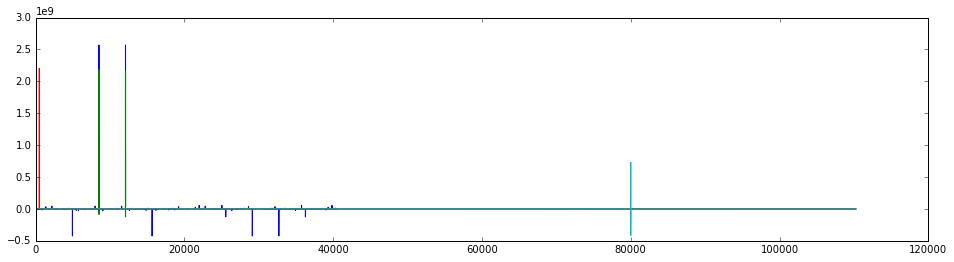

In [12]:
plt.plot(np.fft.rfft(channel))
plt.plot(2e4 * np.fft.rfft(channel_sim))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_min * t)))
plt.plot(2e4 * np.fft.rfft(np.cos(2 * np.pi * freq_max * t)))

In [13]:
Audio(np.cos(2 * np.pi * freq_min * t), rate=rate)

In [14]:
Audio(np.cos(2 * np.pi * freq_max * t), rate=rate)

In [15]:
channel_specs = np.sort([freq_min, noise_freq_1, noise_freq_2, freq_max])
channel_ranges = list(zip(channel_specs, channel_specs[1:]))
[range_start, range_end] = max(channel_ranges,key=lambda range:range[1] - range[0])
[range_start, range_end]

[1209.0, 8000.0]

In [16]:
[pulse_freq_1, pulse_freq_2] = np.linspace(range_start, range_end, 2 + 2)[1:-1]
[pulse_freq_1, pulse_freq_2]

[3472.6666666666665, 5736.333333333333]

In [17]:
pulse_t = np.linspace(0, pulse_dt, rate * pulse_dt)

In [18]:
pulse_1 = np.sin(2 * np.pi * pulse_freq_1 * pulse_t / pulse_dt)
Audio(pulse_1, rate=rate)

In [19]:
pulse_2 = np.sin(2 * np.pi * pulse_freq_2 * pulse_t / pulse_dt)
Audio(pulse_2, rate=rate)

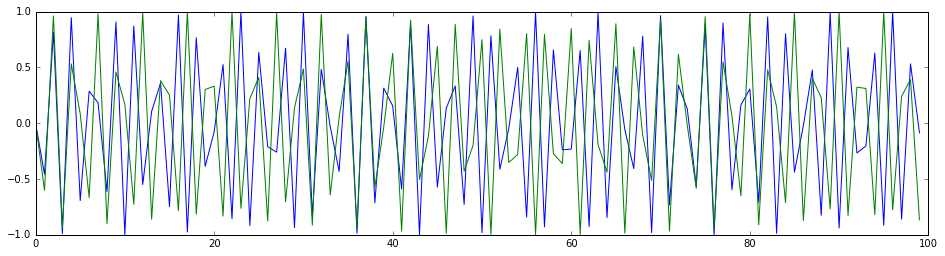

In [20]:
plt.plot(pulse_1[:100])
plt.plot(pulse_2[:100])

In [21]:
np.inner(pulse_1, pulse_2)

-2.9145202162678161

## Emitter

In [22]:
delim = np.random.RandomState(2016).randint(2, size=int(delim_dt / pulse_dt))
len(delim)

40

<Container object of 3 artists>

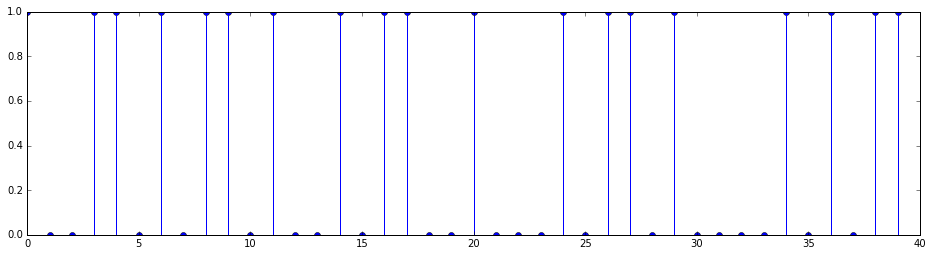

In [23]:
plt.stem(delim)

In [24]:
message = "The mediocre teacher tells."
message_bin = binarize(message)
assert message == textarize(message_bin)
len(message_bin)

216

<Container object of 3 artists>

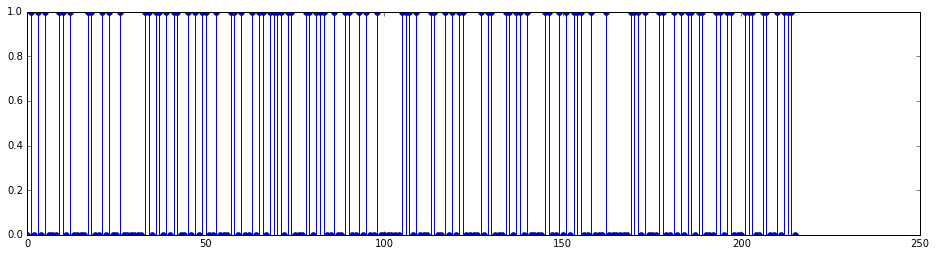

In [25]:
plt.stem(message_bin)

In [26]:
signal_delay = np.zeros(origin_dt * rate)
signal_delim = waveform_encoder(delim, pulse_1, pulse_2)
signal_data = waveform_encoder(message_bin, pulse_1, pulse_2)
signal = np.concatenate((signal_delay, signal_delim, signal_data, signal_delim, signal_delay))
Audio(signal, rate=rate)

In [27]:
signal_t = len(signal) / rate
signal_t

31.6

In [28]:
recorded = signal

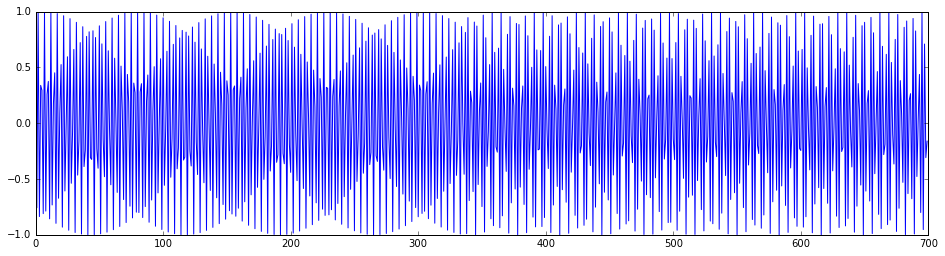

In [29]:
plt.plot(signal[103300:104000])

## Receiver

In [30]:
#recorded = record(32, rate)
#Audio(recorded, rate=rate)

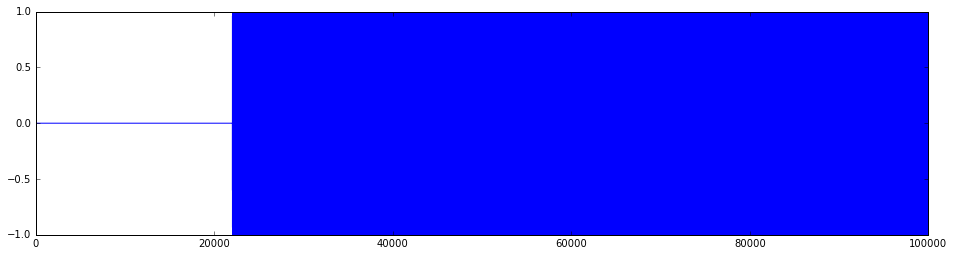

In [31]:
plt.plot(recorded[:100000])

In [32]:
xcorr = np.correlate(recorded, signal_delim)

In [33]:
mid = len(xcorr) // 2
corr_end = len(xcorr) - np.argmax(np.flipud(xcorr[mid:]))
corr_start = corr_end - len(signal_data) - len(signal_delim) - 1
[corr_start, corr_end]

[22050, 586531]

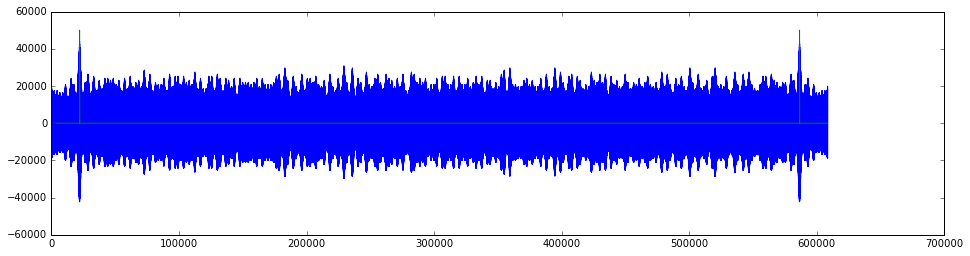

In [34]:
plt.plot(xcorr)
corr_bounds = np.zeros(len(xcorr))
corr_bounds[corr_start] = 5e4
corr_bounds[corr_end] = 5e4
plt.plot(corr_bounds)

In [35]:
received_window = recorded[corr_start:corr_end]
received_align = match_decoder(received_window, pulse_1, pulse_2, rate * pulse_dt)
received = received_align[len(delim) + 1:]

<Container object of 3 artists>

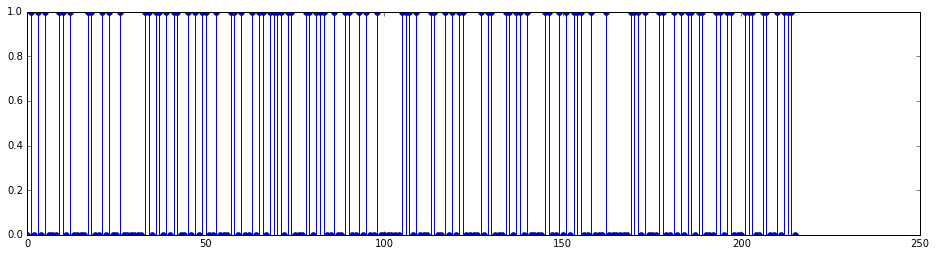

In [36]:
plt.stem(received)

In [37]:
for i in range(0,8):
    print(str(i) + ':  ' + textarize(received[i:]))
          
len(received)

0:  The mediocre teacher tells.
1:  ¨ÐÊ@ÚÊÈÒÞÆäÊ@èÊÂÆÐÊä@èÊØØæ.
2:  Q¡µ¥½ÉÑ¡ÈÑ±±Ì.
3:  £C)k+#K{)£+C+£+cc
4:  FRÖVFö7&RFV6W"FVÆÇ2
¬¬-ìnL¤¬,m®D­e
6:  HYY[ØÜHXXÚ\[Ë
7:  426²²4·±¹2:2°±´2¹:2¶69 


216